In [ ]:
# Run this to setup environment
%pip install -r requirements.txt

In [4]:
import pandas as pd
from processing_utils import *
from rbf import RBF
from rbf_optimization import objective
import optuna
from sklearn.metrics import r2_score, mean_squared_error
import random
%reload_ext autoreload
%autoreload 2

### RBF Network Regression

In [5]:
raw_dataset = pd.read_csv('./dataset/data.csv')

dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True
    ),
    strategy='count_encoding'
)

X_train, y_train, X_val, y_val, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=None,
    as_numpy=False
)

### Example of Optuna hyperparameters optimization with Optuna

In [21]:
rbf = RBF(n_clusters=8, sigma=3.14, normalize=True).fit(X_train, y_train)   # RBF class does data normalization no worries.
y_pred = rbf.predict(X_val)
r2_score(y_val, y_pred)

0.5972875860828044

In [22]:
study = optuna.create_study(
    direction='maximize',
    study_name="RBF hyperparameters optimization",
)

study.optimize(
    lambda trial: objective(
        trial, X_train, y_train, X_val, y_val, normalize=True, metric=r2_score),
    n_trials=10
)

rbf = RBF(study.best_params["n_clusters"], study.best_params["sigma"], normalize=True).fit(X_train, y_train)
y_pred = rbf.predict(X_test)

print("Test mse =", mean_squared_error(rbf.targets_scaler.transform(y_test), rbf.targets_scaler.transform(y_pred)))
print("Test R2 =", r2_score(y_test, y_pred))
print("best parameters:", study.best_params)

[I 2022-06-22 20:51:35,643] A new study created in memory with name: RBF hyperparameters optimization
[I 2022-06-22 20:51:36,606] Trial 0 finished with value: 0.6449349034700815 and parameters: {'n_clusters': 23, 'sigma': 2.7777748127166104}. Best is trial 0 with value: 0.6449349034700815.
[I 2022-06-22 20:51:39,359] Trial 1 finished with value: 0.9915080498169544 and parameters: {'n_clusters': 248, 'sigma': 9.225727221511393}. Best is trial 1 with value: 0.9915080498169544.
[I 2022-06-22 20:51:41,618] Trial 2 finished with value: 0.9776747122532344 and parameters: {'n_clusters': 174, 'sigma': 6.541486019099505}. Best is trial 1 with value: 0.9915080498169544.
[I 2022-06-22 20:51:43,729] Trial 3 finished with value: 0.8141190039332 and parameters: {'n_clusters': 182, 'sigma': 2.241342091692446}. Best is trial 1 with value: 0.9915080498169544.
[I 2022-06-22 20:51:46,213] Trial 4 finished with value: 0.9917059177174694 and parameters: {'n_clusters': 226, 'sigma': 8.959130917797337}. Best

Test mse = 0.00893806066783611
Test R2 = 0.9905130372383235
best parameters: {'n_clusters': 226, 'sigma': 8.959130917797337}


## Performances w.r.t. training dataset size

In [11]:
N_ESSAIS = 50
mses = [[] for _ in range(N_ESSAIS)]
r2_scores = [[] for _ in range(N_ESSAIS)]
percentages = np.linspace(0.2, 1, 15)

In [ ]:
from pathlib import Path
cluster_numbers = []
standard_deviations = []
optimization = np.arange(start=0, stop=N_ESSAIS * len(percentages), step=1)

# this took 15 min on my machine with N_ESSAIS = 5
for k in range(N_ESSAIS):
    seed = random.randint(0, 10000)
    random_state = np.random.RandomState(seed)

    for p in percentages:

        X_train, y_train, X_val, y_val, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
        )

        study = optuna.create_study(
            direction='maximize',
            study_name=f"RBF hyperparameters optimization for percentage p={p} Essai={k}"
        )

        study.optimize(
            lambda trial: objective(
                trial, X_train, y_train, X_val, y_val, normalize=True, metric=r2_score),
            n_trials=10,
            # n_jobs=-1
        )

        rbf = RBF(
            study.best_params["n_clusters"],
            study.best_params["sigma"],
            normalize=True
        ).fit(X_train, y_train)
        y_pred = rbf.predict(X_test)
        mses[k].append(mean_squared_error(y_test, y_pred))
        r2_scores[k].append(r2_score(y_test, y_pred))

        cluster_numbers.append(study.best_params["n_clusters"])
        standard_deviations.append(study.best_params["sigma"])


path = Path('./results/rbf')
mses = np.array(mses)
r2_scores = np.array(r2_scores)

np.save(path/'rbf_mses_var_percentage', mses)
np.save(path/'rbf_scores_var_percentage', r2_scores)


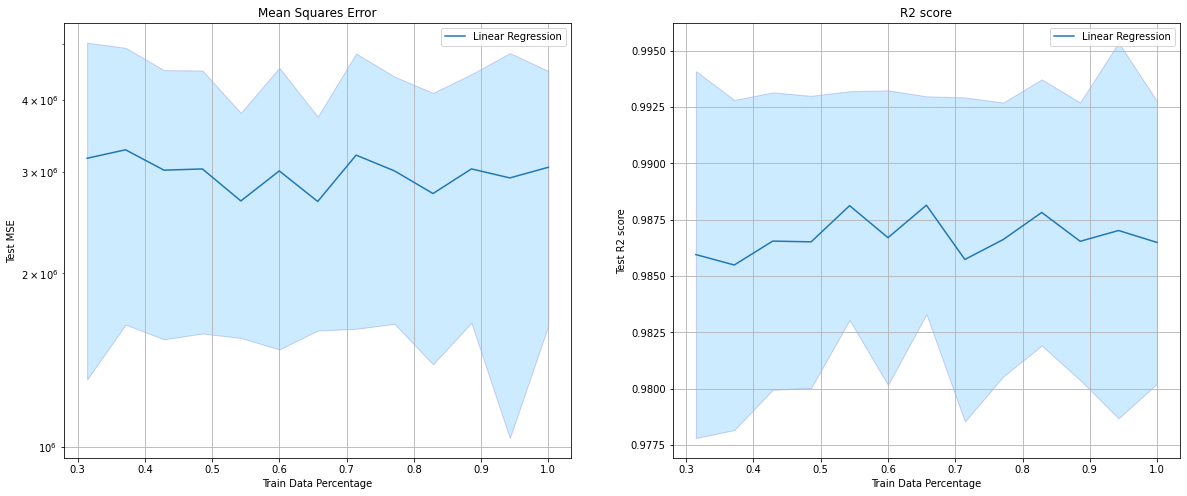

In [13]:
import matplotlib.pyplot as plt
from pathlib import Path

path = Path('./results/rbf')

#mses = np.array(mses)
#r2_scores = np.array(r2_scores)

mses = np.load(path/'rbf_mses_var_percentage.npy')
r2_scores = np.load(path/'rbf_scores_var_percentage.npy')

np.save(path/'rbf_mses_var_percentage', mses)
np.save(path/'rbf_scores_var_percentage', r2_scores)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Mean Squares Error")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test MSE")
plt.grid(True)

final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)

# remove the fucky percentages
rows = np.abs(final_mses) < 10000000
final_mses_chosen = final_mses[rows][2:]
mses_error_chosen = mses_error[rows][2:]
percentages_chosen = percentages[rows][2:]

plt.semilogy(percentages_chosen, final_mses_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(percentages_chosen, final_mses_chosen - mses_error_chosen, final_mses_chosen + mses_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.subplot(1, 2, 2)
plt.title("R2 score")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test R2 score")
plt.grid(True)
plt.yscale('linear')

final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)

# remove fucky values
r2_rows = np.abs(final_r2_score) < 10000
final_r2_score_chosen = final_r2_score[r2_rows][2:]
r2_score_error_chosen = r2_score_error[r2_rows][2:]
r2_percentages_chosen = percentages[r2_rows][2:]

plt.plot(r2_percentages_chosen, final_r2_score_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(r2_percentages_chosen, final_r2_score_chosen - r2_score_error_chosen, final_r2_score_chosen + r2_score_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

## Cross Validation Score

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


def cross_validation_score_of(X: pd.DataFrame, y: pd.DataFrame, n_splits=5, n_clusters=8, sigma=1.):
    kf = KFold(n_splits=n_splits)
    cross_validation_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
        y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]

        rbf_network = RBF(n_clusters, sigma, normalize=True).fit(
            X_train, y_train)
        y_pred = rbf_network.predict(X_test)
        cross_validation_scores.append(
            (r2_score(y_pred[:, 0], y_test[:, 0]),
             r2_score(y_pred[:, 1], y_test[:, 1])))

    return cross_validation_scores


#### Computation of Best RBF Network

In [28]:
study = optuna.create_study(
    direction='minimize',
    study_name="RBF hyperparameters optimization"
)

study.optimize(
    lambda trial: objective(
        trial, X_train, y_train, X_val, y_val, normalize=True, metric=mean_squared_error),
    n_trials=200
)

final_rbf = RBF(study.best_params["n_clusters"], study.best_params["sigma"], normalize=True).fit(X_train, y_train)
y_pred = rbf.predict(X_test)

print("Test mse =", mean_squared_error(y_test, y_pred))
print("Test R2 =", r2_score(y_test, y_pred))
print("best parameters:", study.best_params)

[I 2022-06-22 21:06:00,146] A new study created in memory with name: RBF hyperparameters optimization
[I 2022-06-22 21:06:02,297] Trial 0 finished with value: 18183102.729961812 and parameters: {'n_clusters': 185, 'sigma': 3.7074672551564123}. Best is trial 0 with value: 18183102.729961812.
[I 2022-06-22 21:06:04,828] Trial 1 finished with value: 2770386.450205867 and parameters: {'n_clusters': 236, 'sigma': 7.184605756585465}. Best is trial 1 with value: 2770386.450205867.
[I 2022-06-22 21:06:07,292] Trial 2 finished with value: 5203326.427578593 and parameters: {'n_clusters': 227, 'sigma': 6.177992182792159}. Best is trial 1 with value: 2770386.450205867.
[I 2022-06-22 21:06:09,058] Trial 3 finished with value: 31152357.804660562 and parameters: {'n_clusters': 128, 'sigma': 3.0858281016452387}. Best is trial 1 with value: 2770386.450205867.
[I 2022-06-22 21:06:10,090] Trial 4 finished with value: 76379323.71530291 and parameters: {'n_clusters': 31, 'sigma': 2.413672937787253}. Best i

Test mse = 1532259.5910276459
Test R2 = 0.9933806095524936
best parameters: {'n_clusters': 246, 'sigma': 9.984280712835586}


/home/hugo/Projects/dm_project/.venv/lib64/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [9]:
best_params = {'n_clusters': 246, 'sigma': 9.984280712835586}

#### Computation of it's Cross Validation Score

In [16]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

cross_val_scores = cross_validation_score_of(X, y, **best_params)

In [21]:
print("RBF Cross Validation Score =", np.mean(cross_val_scores, axis=0))

RBF Cross Validation Score = [0.99199898 0.99198635]


In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


def cross_validation_mse_of(X: pd.DataFrame, y: pd.DataFrame, n_splits=5, n_clusters=8, sigma=1., denormalize=True):
    kf = KFold(n_splits=n_splits)
    cross_validation_mses = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
        y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]

        rbf_network = RBF(n_clusters, sigma, normalize=True).fit(
            X_train, y_train)

        y_pred = rbf_network.predict(X_test, denormalize)
        print(y_pred[0, :], y_test[0, :])
        if not denormalize:
            y_test = rbf_network.targets_scaler.transform(y_test)
        cross_validation_mses.append((
            mean_squared_error(y_pred[:, 0], y_test[:, 0]),
            mean_squared_error(y_pred[:, 1], y_test[:, 1]),
        ))

    return cross_validation_mses


In [29]:
denormalized_cross_val_mses = cross_validation_mse_of(X, y, denormalize=True, **best_params)
print("RBF Denormalized Cross Validation MSES =", np.mean(denormalized_cross_val_mses, axis=0))

[-59744.09641073 -59653.17276412] [-59984.44052 -59891.92346]
[-72582.65252827 -72441.19243688] [-72088.90358 -71949.03197]
[-35204.52241135 -35153.04384056] [-35447.69898 -35394.0583 ]
[-64315.07753686 -64264.15454537] [-59932.63758 -59889.96439]
[-76083.85791581 -75853.49405593] [-75933.89514 -75704.41099]
RBF Denormalized Cross Validation MSES = [1687162.65458226 1683766.86736788]


In [30]:
normalized_cross_val_mses = cross_validation_mse_of(X, y, denormalize=False, **best_params)
print("RBF Normalized Cross Validation MSES =", np.mean(normalized_cross_val_mses, axis=0))

[-0.27993413 -0.28097513] [-59984.44052 -59891.92346]
[-1.07567462 -1.07449186] [-72088.90358 -71949.03197]
[1.38143986 1.38064395] [-35447.69898 -35394.0583 ]
[-0.38651611 -0.39055997] [-59932.63758 -59889.96439]
[-1.31735098 -1.31058512] [-75933.89514 -75704.41099]
RBF Normalized Cross Validation MSES = [0.00701638 0.00702371]
